# Regressziós feladat megoldása Torch segítségével

In [1]:
require "torch"
require "nn"
require "optim"
GITHUB=true

In [2]:
mean=0
std=1

-- general egy szinuszjelet
function genSin(from, to, points, standard)
    local dat=torch.Tensor(points):range(from,to):apply(math.rad)
    local result=torch.cat(dat:clone(),dat:clone():apply(math.sin)*0.9,2)
    if(standard) then
        mean=result[{{},1}]:mean()
        std=result[{{},1}]:std()
    end
    result[{{},1}]=(result[{{},1}]-mean)/(std)
    return result:clone()
end

-- letrehoz egy neuralis halot
function createModel(inputs, hiddens, outputs)
    local model=nn.Sequential()
    model:add(nn.Linear(inputs,hiddens[1]))
    model:add(nn.Tanh())
    if table.getn(hiddens)>1 then
        for i=1,table.getn(hiddens)-1 do 
            model:add(nn.Linear(hiddens[i],hiddens[i+1]))
            model:add(nn.Tanh())
        end
    end
    model:add(nn.Linear(hiddens[table.getn(hiddens)],outputs))
    model:add(nn.Tanh())
    return model
end

-- a halo tanitasa
function trainModel(net, trainingSet, criterion, optPar)
   params,gradParams=net:getParameters()
   local batchInputs=torch.Tensor(batchSize,trainingSet:size(2)-1)
   local batchLabels=torch.DoubleTensor(batchSize,1)
   for i=1,epochs do
        local shuffle=torch.randperm(trainingSet:size(1))
        for k=1,trainingSet:size(1),batchSize do 
            l=1
            for j=k,math.min(k+batchSize-1,trainingSet:size(1)) do
            batchInputs[l]=trainingSet[{shuffle[j],{1,-2}}]
            batchLabels[l]=trainingSet[{shuffle[j],-1}]
            l=l+1
        end
        local function feval(params)
            gradParams:zero()
            local outputs=net:forward(batchInputs) 
            local loss=criterion:forward(outputs,batchLabels) 
            local dloss_doutput=criterion:backward(outputs,batchLabels)
            net:backward(batchInputs,dloss_doutput)
            return loss,gradParams
        end
        _,loss=optim.sgd(feval,params,optPar)
    end
    if i%100==0 then print(string.format("Iteration %d, error is %g.",i,loss[1])) end
    end
end

In [3]:
-- a tanito adatok
data=genSin(1,1000,1000,true)
-- a halo
model=createModel(data:size(2)-1,{40,40},1)
-- az optimalizacio parameterei
criterion=nn.MSECriterion()
epochs=500
batchSize=200
optPar={
    learningRate=0.05,
    weightDecay=1e-4,
    momentum=0.9,
    nesterov=false,
    dampening=0,
    learningRateDecay=0
}
-- tanitas
if(batchSize>data:size(1)) then error() end
trainModel(model,data,criterion,optPar)

Iteration 100, error is 0.0209572.	


Iteration 200, error is 0.00611903.	


Iteration 300, error is 0.00680073.	


Iteration 400, error is 0.00500364.	


Iteration 500, error is 0.00403927.	


### Tesztelés

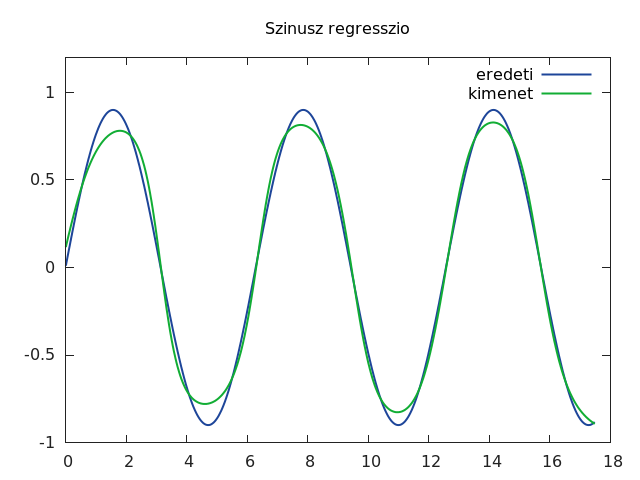

In [4]:
function plotSin(trainData,testData,pred,git)
    local x1=trainData[{{},1}]:clone():mul(std):add(mean)
    local y1=trainData[{{},-1}]
    local x2=testData[{{},1}]:clone():mul(std):add(mean)
    local y2=pred:reshape(pred:size(1))
    if git then
        require "gnuplot"
        gnuplot.pngfigure("plot.png")
        gnuplot.plot({"eredeti",x1,y1,"-"},
                     {"kimenet",x2,y2,"-"})
        gnuplot.title("Szinusz regresszio")
        gnuplot.axis({"","","",math.max(y1:max(),y2:max())+0.3})
        gnuplot.plotflush()
        local t0=os.clock()
        while ((os.clock()-t0)<3) do end
        itorch.image("plot.png")
        os.remove("plot.png")
    else
        local plot=itorch.Plot()
        plot:line(x1,y1,"blue","eredeti")
        plot:line(x2,y2,"green","kimenet")
        plot:title("Szinusz regresszio")
        plot:legend(true)
        plot:draw()
    end
end

local testData=genSin(1,1000,1000,false)
local pred=model:forward(testData[{{},{1,-2}}])
plotSin(data,testData,pred,GITHUB)

### Extrapolációs képesség vizsgálata

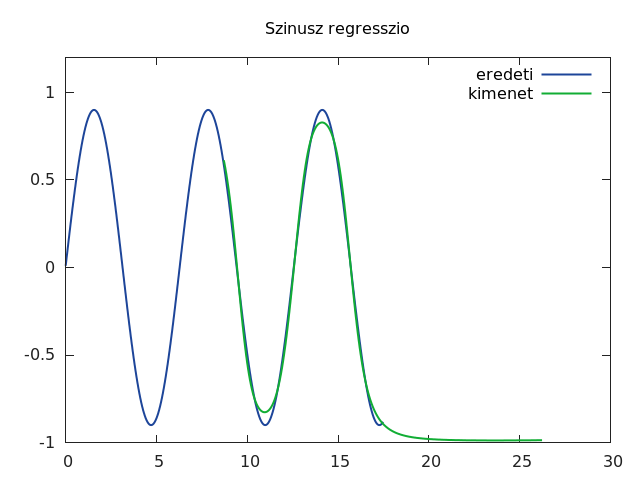

In [5]:
local testData=genSin(500,1500,1000,false)
local pred=model:forward(testData[{{},{1,-2}}])
plotSin(data,testData,pred,GITHUB)

### Az extrapoláció javítása visszacsatolással

In [6]:
function genDataSinFeedback(from, to, resolution, feedback)
    local dat = torch.Tensor(resolution):range(from,to):apply(math.rad)
    local result=dat:clone()
    for i=1,feedback do 
        result=torch.cat(result:clone(), torch.cat(torch.Tensor(i):zero(),dat[{{i+1,-1}}]):clone():apply(math.sin)*0.9,2)
    end
    
    result=torch.cat(result:clone(), dat:clone():apply(math.sin)*0.9,2)

    return result:clone()
end

In [7]:
-- a tanito adatok
data=genDataSinFeedback(1,1000,1000,1,false)
-- a halo
model=createModel(data:size(2)-1,{40,40},1)
-- az optimalizacio parameterei
criterion=nn.MSECriterion()
epochs=100
batchSize=200
optPar={
    learningRate=0.05,
    weightDecay=1e-4,
    momentum=0.9,
    nesterov=false,
    dampening=0,
    learningRateDecay=0
}
-- tanitas
if(batchSize>data:size(1)) then error() end
trainModel(model,data,criterion,optPar)

Iteration 100, error is 0.00481742.	


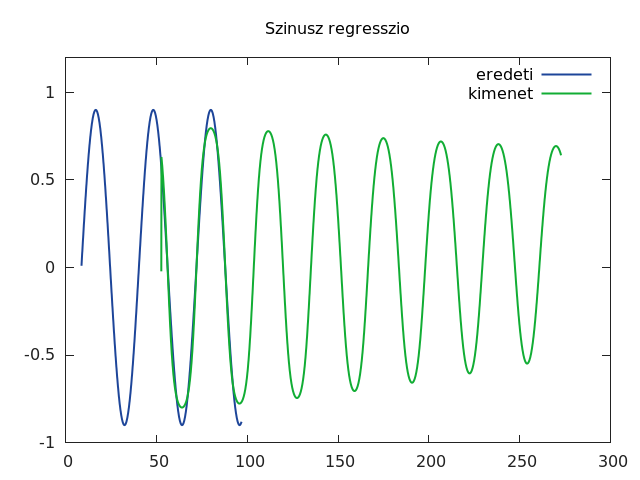

In [8]:
testData=genDataSinFeedback(500,3000,1000,1,true)
pred=model:forward(testData[{{},{1,-2}}])
plotSin(data,testData,pred,GITHUB)